# Grid algorithms for hierarchical models

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

It is widely believed that grid algorithms are only practical for models with 1-3 parameters, or maybe 4-5 if you are careful.
[I've said so myself](https://allendowney.github.io/ThinkBayes2/chap19.html).

But recently I used a grid algorithm to solve the [emitter-detector problem](https://www.allendowney.com/blog/2021/09/05/emitter-detector-redux/), and along the way I noticed something about the structure of the problem: although the model has two parameters, the data only depend on one of them.
And that made it possible to evaluate the likelihood function, and update the model, very efficiently.

Then I realized that many hierarchical models have a similar structure: the data depend on a small number of parameters, which depend on a small number of hyperparameters.
I wondered whether the same method would generalize to more complex models, and it does.

As an example, in this notebook I'll use a logitnormal-binomial hierarchical model to solve a problem with two hyperparameters and 13 parameters, with a total run time that's not just practical; it's substantially faster than MCMC.




In [1]:
# If we're running on Colab, install libraries
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz
    !pip install empiricaldist

In [2]:
# PyMC generates a FutureWarning we don't need to deal with yet

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import matplotlib.pyplot as plt

def legend(**options):
    """Make a legend only if there are labels."""
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend(**options)

In [4]:
def decorate(**options):
    plt.gca().set(**options)
    legend()
    plt.tight_layout()

In [5]:
from empiricaldist import Cdf

def compare_cdf(pmf, sample):
    pmf.make_cdf().step(label='grid')
    Cdf.from_seq(sample).plot(label='mcmc')
    print(pmf.mean(), sample.mean())
    decorate()

In [6]:
from empiricaldist import Pmf

def make_pmf(ps, qs, name):
    pmf = Pmf(ps, qs)
    pmf.normalize()
    pmf.index.name = name
    return pmf

## Heart Attack Data

The problem I'll solve is based on [Chapter 10 of *Probability and Bayesian Modeling*](https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html#example-deaths-after-heart-attack); it uses data on death rates due to heart attack for patients treated at various hospitals in New York City.

We can use Pandas to read the data into a `DataFrame`.

In [7]:
import os

filename = 'DeathHeartAttackManhattan.csv'
if not os.path.exists(filename):
    !wget https://github.com/AllenDowney/BayesianInferencePyMC/raw/main/DeathHeartAttackManhattan.csv

In [8]:
import pandas as pd

df = pd.read_csv(filename)
df

,Hospital,Cases,Deaths,Death %
0,Bellevue Hospital Center,129,4,3.101
1,Harlem Hospital Center,35,1,2.857
2,Lenox Hill Hospital,228,18,7.894
3,Metropolitan Hospital Center,84,7,8.333
4,Mount Sinai Beth Israel,291,24,8.247
5,Mount Sinai Hospital,270,16,5.926
6,Mount Sinai Roosevelt,46,6,13.043
7,Mount Sinai St. Luke’s,293,19,6.485
8,NYU Hospitals Center,241,15,6.224
9,NYP Hospital - Allen Hospital,105,13,12.381


The columns we need are `Cases`, which is the number of patients treated at each hospital, and `Deaths`, which is the number of those patients who died.

In [9]:
data_ns = df['Cases'].values
data_ks = df['Deaths'].values

## Solution with PyMC

Here's a hierarchical model that estimates the death rate for each hospital, and simultaneously estimates the distribution of rates across hospitals.

In [10]:
import pymc3 as pm
import theano.tensor as tt

def make_model():
    with pm.Model() as model:
        mu = pm.Normal('mu', 0, 2)
        sigma = pm.HalfNormal('sigma', sigma=1)
        xs = pm.LogitNormal('xs', mu=mu, sigma=sigma, shape=len(data_ns))
        ks = pm.Binomial('ks', n=data_ns, p=xs, observed=data_ks)
    return model

CPU times: user 878 ms, sys: 55.8 ms, total: 933 ms
Wall time: 2.23 s


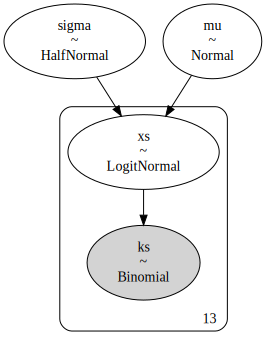

In [11]:
%time model = make_model()
pm.model_to_graphviz(model)

In [12]:
with model:
    pred = pm.sample_prior_predictive(1000)
    %time trace = pm.sample(500, target_accept=0.97)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xs, sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 5 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.861547182661652, but should be close to 0.97. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 5.13 s, sys: 177 ms, total: 5.3 s
Wall time: 9.61 s


Here are the posterior distributions of the hyperparameters

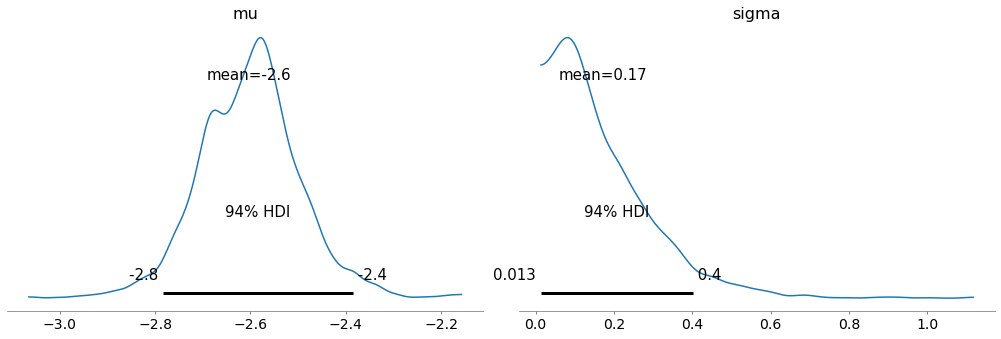

In [13]:
import arviz as az

with model:
    az.plot_posterior(trace, var_names=['mu', 'sigma'])

And we can extract the posterior distributions of the xs.

In [14]:
trace_xs = trace['xs'].transpose()
trace_xs.shape

(13, 2000)

As an example, here's the posterior distribution of x for the first hospital.

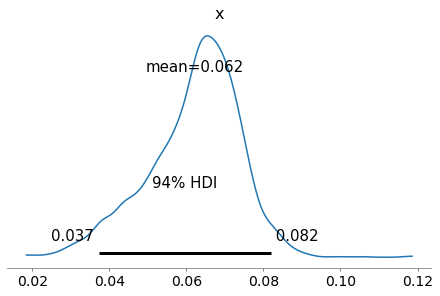

In [15]:
with model:
    az.plot_posterior(trace_xs[0])

## The grid priors

Now let's solve the same problem using a grid algorithm.
I'll use the same priors for the hyperparameters, approximated by a grid with about 100 elements in each dimension.

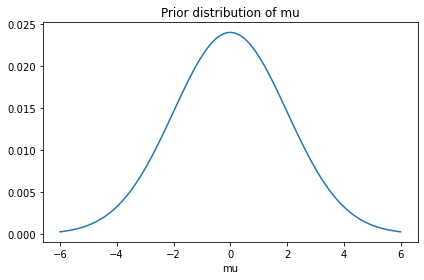

In [16]:
import numpy as np
from scipy.stats import norm

mus = np.linspace(-6, 6, 101)
ps = norm.pdf(mus, 0, 2)
prior_mu = make_pmf(ps, mus, 'mu')

prior_mu.plot()
decorate(title='Prior distribution of mu')

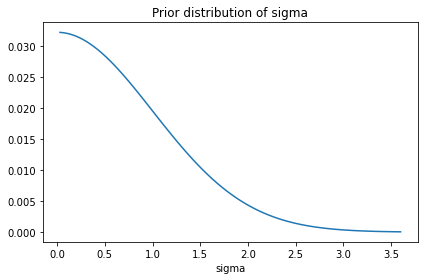

In [17]:
from scipy.stats import logistic

sigmas = np.linspace(0.03, 3.6, 90)
ps = norm.pdf(sigmas, 0, 1)
prior_sigma = make_pmf(ps, sigmas, 'sigma')

prior_sigma.plot()
decorate(title='Prior distribution of sigma')

The following cells confirm that these priors are consistent with the prior samples from PyMC.

2.6020852139652106e-18 -0.009345292509670792


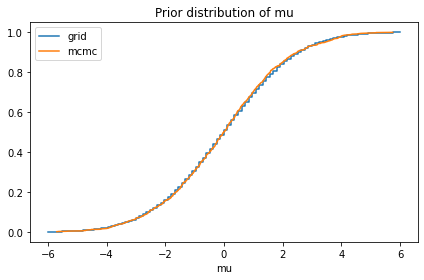

In [18]:
compare_cdf(prior_mu, pred['mu'])
decorate(title='Prior distribution of mu')

0.8033718951689776 0.7949104557766841


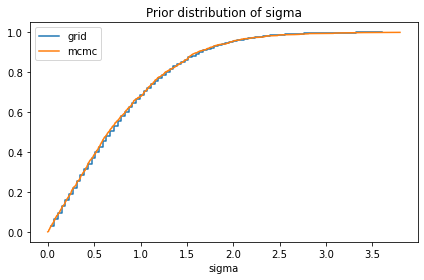

In [19]:
compare_cdf(prior_sigma, pred['sigma'])
decorate(title='Prior distribution of sigma')


## The joint distribution of hyperparameters

I'll use `make_joint` to make an array that represents the joint prior distribution of the hyperparameters.

In [20]:
def make_joint(prior_x, prior_y):
    X, Y = np.meshgrid(prior_x.ps, prior_y.ps, indexing='ij')
    hyper = X * Y
    return hyper

In [21]:
prior_hyper = make_joint(prior_mu, prior_sigma)
prior_hyper.shape

(101, 90)

Here's what it looks like.

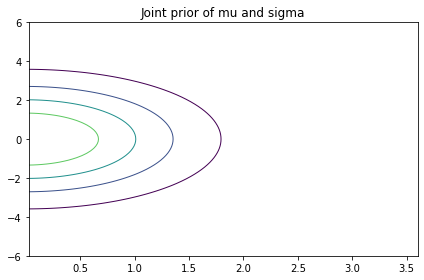

In [22]:
import pandas as pd
from utils import plot_contour

plot_contour(pd.DataFrame(prior_hyper, index=mus, columns=sigmas))
decorate(title="Joint prior of mu and sigma")

## Joint prior of hyperparameters and x

Now we're ready to lay out the grid for x, which is the proportion we'll estimate for each hospital.

In [69]:
xs = np.linspace(0.01, 0.99, 295)
M, S, X = np.meshgrid(mus, sigmas, xs, indexing='ij')

array([0.01      , 0.01333333, 0.01666667, 0.02      , 0.02333333,
       0.02666667, 0.03      , 0.03333333, 0.03666667, 0.04      ,
       0.04333333, 0.04666667, 0.05      , 0.05333333, 0.05666667,
       0.06      , 0.06333333, 0.06666667, 0.07      , 0.07333333,
       0.07666667, 0.08      , 0.08333333, 0.08666667, 0.09      ,
       0.09333333, 0.09666667, 0.1       , 0.10333333, 0.10666667,
       0.11      , 0.11333333, 0.11666667, 0.12      , 0.12333333,
       0.12666667, 0.13      , 0.13333333, 0.13666667, 0.14      ,
       0.14333333, 0.14666667, 0.15      , 0.15333333, 0.15666667,
       0.16      , 0.16333333, 0.16666667, 0.17      , 0.17333333,
       0.17666667, 0.18      , 0.18333333, 0.18666667, 0.19      ,
       0.19333333, 0.19666667, 0.2       , 0.20333333, 0.20666667,
       0.21      , 0.21333333, 0.21666667, 0.22      , 0.22333333,
       0.22666667, 0.23      , 0.23333333, 0.23666667, 0.24      ,
       0.24333333, 0.24666667, 0.25      , 0.25333333, 0.25666

For each pair of hyperparameters, we'll compute the distribution of `x`.

In [24]:
from scipy.special import logit

LO = logit(X)
LO.sum()

-2.4004975784919225e-10

In [25]:
from scipy.stats import norm

%time normpdf = norm.pdf(LO, M, S)
normpdf.sum()

CPU times: user 61.4 ms, sys: 8.36 ms, total: 69.8 ms
Wall time: 68.2 ms


144354.33908990037

We can speed this up by computing skipping the terms that don't depend on x

In [26]:
%%time

z = (LO-M) / S
normpdf = np.exp(-z**2/2)

CPU times: user 20 ms, sys: 10.6 ms, total: 30.6 ms
Wall time: 29.3 ms


Now we need to normalize each distribution of `x`.

In [27]:
totals = normpdf.sum(axis=2)
totals.sum()

643232.4732216377

In [28]:
shape = totals.shape + (1,)
totals = totals.reshape(shape)

out = np.zeros_like(normpdf)
normpdf = np.divide(normpdf, totals,
                    out=out, where=(totals!=0))
normpdf.sum()

9084.0

The result is an array that contains the distribution of `x` for each pair of hyperparameters.

Now, to get the prior distribution, we multiply through by the joint distribution of the hyperparameters.

In [29]:
def make_prior(hyper):

    # reshape hyper so we can multiply along axis 0
    shape = hyper.shape + (1,)
    prior = normpdf * hyper.reshape(shape)

    return prior

In [30]:
%time prior = make_prior(prior_hyper)
prior.sum()

CPU times: user 3.18 ms, sys: 1.15 ms, total: 4.33 ms
Wall time: 3.39 ms


0.9999377812780402

The result is a 3-D array that represents the joint prior distribution of `mu`, `sigma`, and `x`.

To check that it is correct, I'll extract the marginal distributions and compare them to the priors.

In [31]:
def marginal(joint, axis):
    axes = [i for i in range(3) if i != axis]
    return joint.sum(axis=tuple(axes))

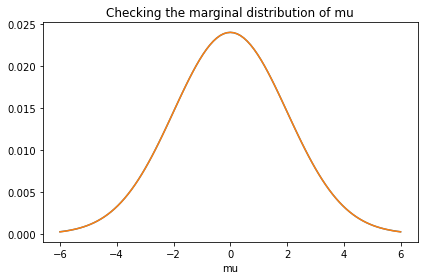

In [32]:
prior_mu.plot()
marginal_mu = Pmf(marginal(prior, 0), mus)
marginal_mu.plot()
decorate(title='Checking the marginal distribution of mu')

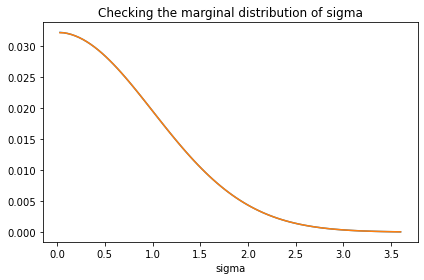

In [33]:
prior_sigma.plot()
marginal_sigma = Pmf(marginal(prior, 1), sigmas)
marginal_sigma.plot()
decorate(title='Checking the marginal distribution of sigma')

We didn't compute the prior distribution of `x` explicitly; it follows from the distribution of the hyperparameters. But we can extract the prior marginal of `x` from the joint prior.

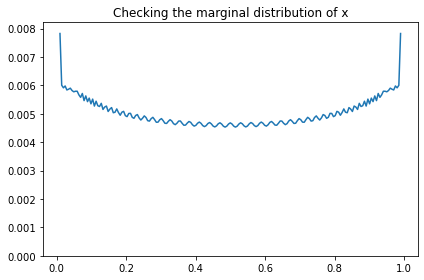

In [34]:
marginal_x = Pmf(marginal(prior, 2), xs)
marginal_x.plot()
decorate(title='Checking the marginal distribution of x',
         ylim=[0, np.max(marginal_x) * 1.05])

And compare it to the prior sample from PyMC.

In [35]:
pred_xs = pred['xs'].transpose()
pred_xs.shape

(13, 1000)

0.49996889063901945 0.492955515342978


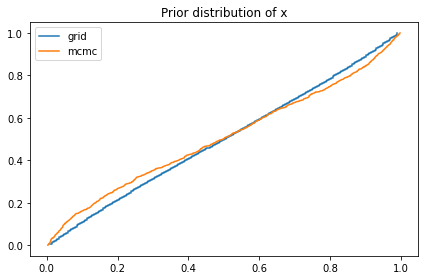

In [36]:
compare_cdf(marginal_x, pred_xs[0])
decorate(title='Prior distribution of x')

TODO: Not quite...

In addition to the marginals, we'll also find it useful to extract the joint marginal distribution of the hyperparameters.

In [37]:
def get_hyper(joint):
    return joint.sum(axis=2)

In [38]:
hyper = get_hyper(prior)

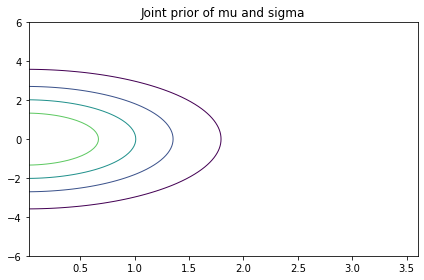

In [39]:
plot_contour(pd.DataFrame(hyper, 
                          index=mus, 
                          columns=sigmas))
decorate(title="Joint prior of mu and sigma")

## The Update

The likelihood of the data only depends on `x`, so we can compute it like this.

In [40]:
from scipy.stats import binom

data_k = data_ks[0]
data_n = data_ns[0]

like_x = binom.pmf(data_k, data_n, xs)
like_x.shape

(199,)

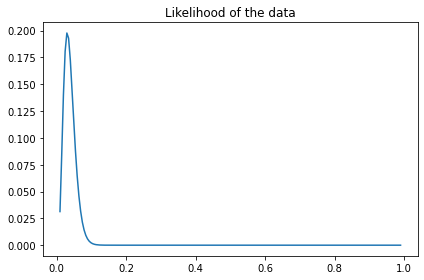

In [41]:
plt.plot(xs, like_x)
decorate(title='Likelihood of the data')

And here's the update.

In [42]:
def update(prior, data):
    n, k = data
    like_x = binom.pmf(k, n, xs)
    posterior = prior * like_x
    posterior /= posterior.sum()
    return posterior

In [43]:
data = data_n, data_k
%time posterior = update(prior, data)

CPU times: user 3.17 ms, sys: 13.5 ms, total: 16.7 ms
Wall time: 5.36 ms


## Serial updates

At this point we can do an update based on a single hospital, but how do we update based on all of the hospitals.

As a step toward the right answer, I'll start with a wrong answer, which is to do the updates in series.

After each update, we extract the posterior distribution of the hyperparameters and use it to create the prior for the next update.

At the end, the posterior distribution of hyperparameters is correct, and the marginal posterior of `x` for the *last* hospital is correct, but the other marginals are wrong because they do not take into account data from subsequent hospitals.

In [44]:
def multiple_updates(prior, ns, ks):
    for data in zip(ns, ks):
        print(data)
        posterior = update(prior, data)
        hyper = get_hyper(posterior)
        prior = make_prior(hyper)
    return posterior

In [45]:
%time posterior = multiple_updates(prior, data_ns, data_ks)

(129, 4)
(35, 1)
(228, 18)
(84, 7)
(291, 24)
(270, 16)
(46, 6)
(293, 19)
(241, 15)
(105, 13)
(353, 25)
(250, 11)
(41, 4)
CPU times: user 147 ms, sys: 26.9 ms, total: 174 ms
Wall time: 133 ms


Here are the posterior distributions of the hyperparameters, compared to the results from PyMC.

-2.6478530928867894 -2.602012761257397


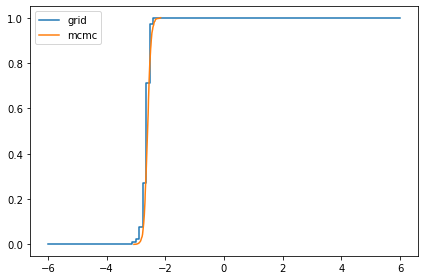

In [46]:
marginal_mu = Pmf(marginal(posterior, 0), mus)
compare_cdf(marginal_mu, trace['mu'])

0.19299521929134822 0.17176887222638101


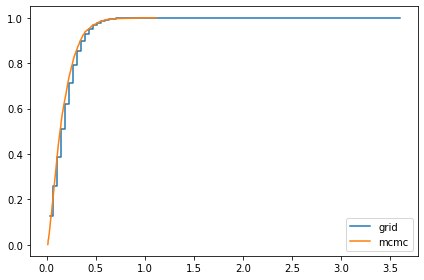

In [47]:
marginal_sigma = Pmf(marginal(posterior, 1), sigmas)
compare_cdf(marginal_sigma, trace['sigma'])

0.07330233409685402 0.07214450639787627


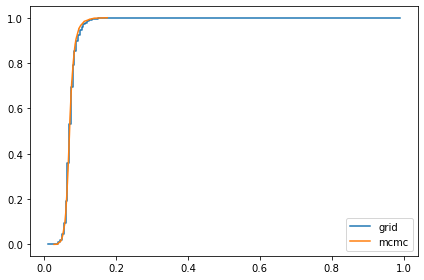

In [48]:
marginal_x = Pmf(marginal(posterior, 2), xs)
compare_cdf(marginal_x, trace_xs[-1])

## Parallel updates

Doing serial updates is not quite right, but it gives us an insight.

Suppose we start with a uniform distribution for the hyperparameters and do an update with data from one hospital. If we extract the posterior joint distribution of the hyperparameters, what we get is the likelihood function associated with one dataset.

The following function computes these likelihood functions and saves them in an array called `hyper_likelihood`.

In [49]:
def compute_hyper_likelihood(ns, ks):
    shape = ns.shape + mus.shape + sigmas.shape
    hyper_likelihood = np.empty(shape)
    
    for i, data in enumerate(zip(ns, ks)):
        print(data)
        n, k = data
        like_x = binom.pmf(k, n, xs)
        posterior = normpdf * like_x
        hyper_likelihood[i] = get_hyper(posterior)
    return hyper_likelihood

In [50]:
%time hyper_likelihood = compute_hyper_likelihood(data_ns, data_ks)

(129, 4)
(35, 1)
(228, 18)
(84, 7)
(291, 24)
(270, 16)
(46, 6)
(293, 19)
(241, 15)
(105, 13)
(353, 25)
(250, 11)
(41, 4)
CPU times: user 72 ms, sys: 46.2 ms, total: 118 ms
Wall time: 61.4 ms


We can multiply this out to get the product of the likelihoods.

In [51]:
%time like_hyper_all = hyper_likelihood.prod(axis=0)
like_hyper_all.sum()

CPU times: user 366 µs, sys: 0 ns, total: 366 µs
Wall time: 226 µs


1.6818189633990558e-14

This is useful because it provides an efficient way to compute the marginal posterior distribution of `x` for any hospital.
Here's an example.

In [52]:
i = 3
data = data_ns[i], data_ks[i]
data

(84, 7)

Suppose we did the updates serially and saved this hospital for last.
The prior distribution for the final update would reflect the updates from all previous hospitals, which we can compute by dividing out `hyper_likelihood[i]`.

In [53]:
def divide(x, y):
    out = np.zeros_like(x)
    return np.divide(x, y, out=out, where=(y!=0))    

In [54]:
out = np.zeros_like(prior_hyper)
%time hyper_i = divide(prior_hyper * like_hyper_all, hyper_likelihood[i])
hyper_i.sum()

CPU times: user 270 µs, sys: 0 ns, total: 270 µs
Wall time: 129 µs


4.3270103421435697e-17

In [55]:
prior_i = make_prior(hyper_i) 

In [56]:
posterior_i = update(prior_i, data)

And we can confirm that the results are similar to the results from PyMC.

In [57]:
marginal_mu = Pmf(marginal(posterior_i, 0), mus)
marginal_sigma = Pmf(marginal(posterior_i, 1), sigmas)
marginal_x = Pmf(marginal(posterior_i, 2), xs)

-2.6478530928867907 -2.602012761257397


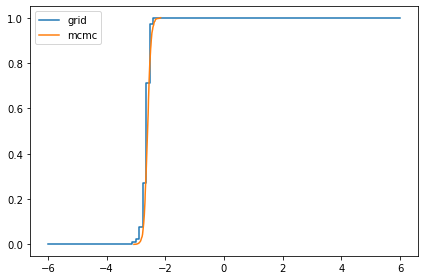

In [58]:
compare_cdf(marginal_mu, trace['mu'])

0.19299521929134833 0.17176887222638101


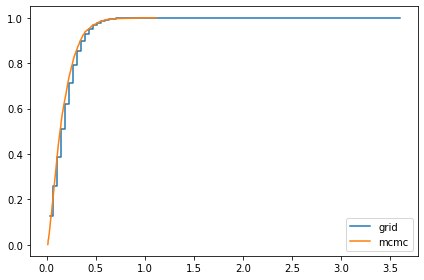

In [59]:
compare_cdf(marginal_sigma, trace['sigma'])

0.07244681880785644 0.07219919574340486


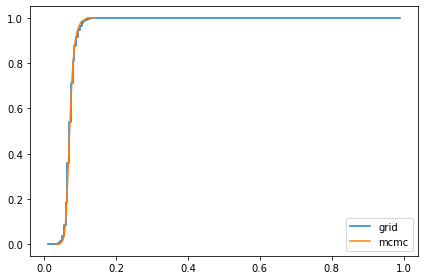

In [60]:
compare_cdf(marginal_x, trace_xs[i])

## Compute all marginals

The following function computes the marginals for all hospitals and stores the results in an array.

In [61]:
def compute_all_marginals(ns, ks):
    shape = len(ns), len(xs)
    marginal_xs = np.zeros(shape)
    numerator = prior_hyper * like_hyper_all
    
    for i, data in enumerate(zip(ns, ks)):
        hyper_i = divide(numerator, hyper_likelihood[i])
        prior_i = make_prior(hyper_i) 
        posterior_i = update(prior_i, data)
        marginal_xs[i] = marginal(posterior_i, 2)
        
    return marginal_xs

In [62]:
%time marginal_xs = compute_all_marginals(data_ns, data_ks)

CPU times: user 149 ms, sys: 42 ms, total: 190 ms
Wall time: 129 ms


Here's what the results look like, compared to the results from PyMC.

0.06120395372929756 0.062038550827242855
0.06651007617158199 0.06683468391558693
0.07267030606551872 0.07250370953108362
0.07244681880785644 0.07219919574340486
0.074306444142694 0.07397885717225974
0.06604166680264652 0.0666959402193298
0.07774989381124277 0.07656152546813723
0.06786829173929548 0.06804365385014821
0.06721452237722864 0.06755256217536561
0.08185013844648342 0.07980524302540638
0.0700279141864477 0.0699381092897948
0.0613282721894433 0.062300362419528764
0.07330233409685404 0.07214450639787627


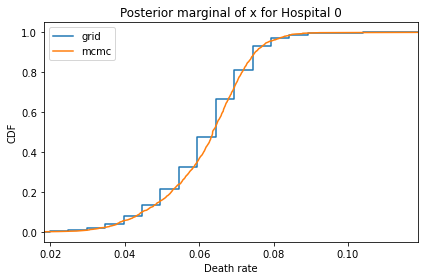

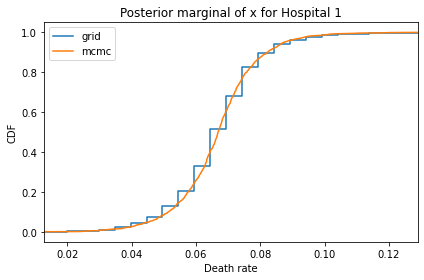

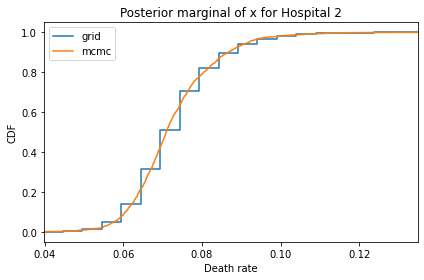

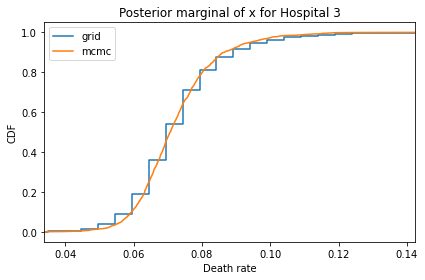

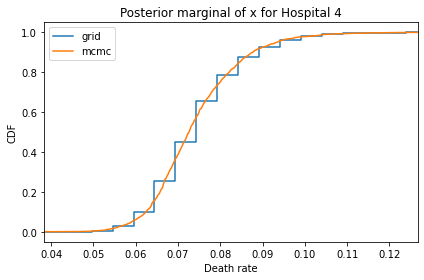

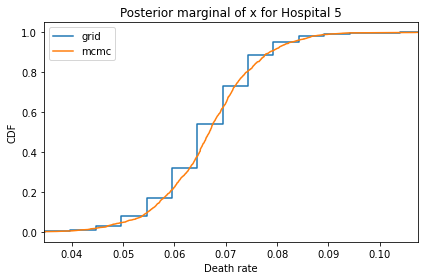

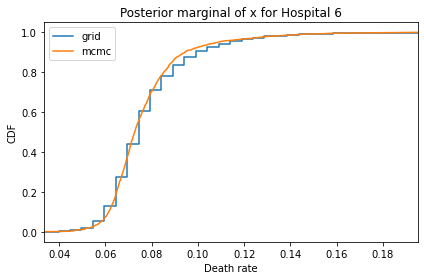

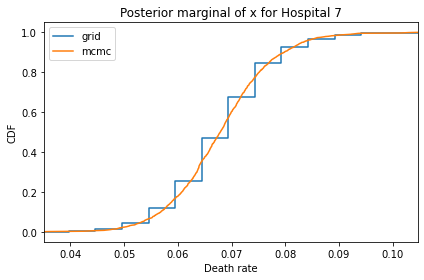

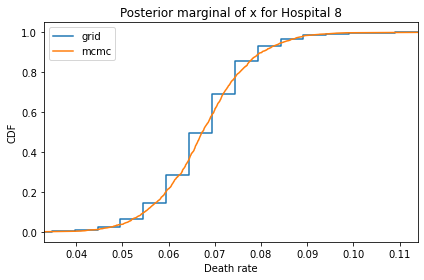

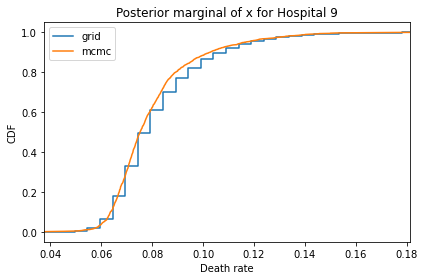

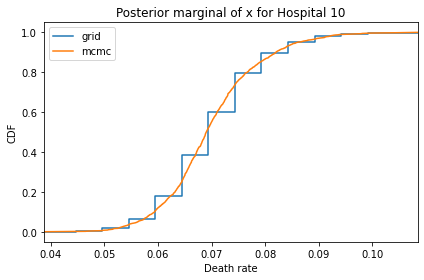

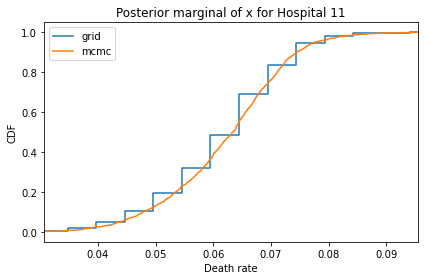

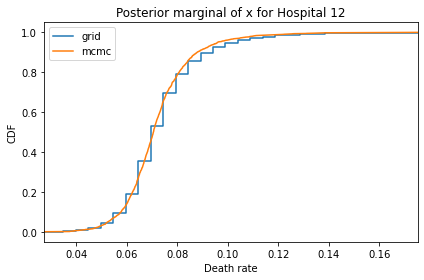

In [63]:
for i, ps in enumerate(marginal_xs):
    pmf = Pmf(ps, xs)
    plt.figure()
    compare_cdf(pmf, trace_xs[i])
    decorate(title=f'Posterior marginal of x for Hospital {i}',
             xlabel='Death rate',
             ylabel='CDF',
             xlim=[trace_xs[i].min(), trace_xs[i].max()])

In [64]:
for i, ps in enumerate(marginal_xs):
    pmf = Pmf(ps, xs)
    diff = abs(pmf.mean() - trace_xs[i].mean()) / pmf.mean()
    print(diff * 100)

1.363632652943769
0.48805799465260863
0.22924980429406316
0.3417997760651597
0.44085943583193354
0.9906979159663836
1.5284501172317988
0.2583859212581214
0.5029267280064684
2.498340821273095
0.12824157008846518
1.5850605200203187
1.5795236444284737
